# Lesson 9 - Convolutional Neural Networks

## Author - Lukas Fiorio

## Instructions

- Read data. Split into train/validate/test. Pre-process.
- Build and evaluate a CNN model
- Apply augmentation and evaluate
- Apply dilation and evaluate
- Summarize findings

## Introduction

In this module we will be performing multi-class prediction on image data (from `cifar10`) using convolutional neural networks.

In [1]:
# Import libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import math

from matplotlib.ticker import MaxNLocator # integer tick labels
from numpy.random import seed

import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D

from scipy import ndimage # image rotation
from skimage import transform # image crop (resizing)
import random # random image sampling

from sklearn.metrics import confusion_matrix
from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report

In [2]:
# set package options
pd.set_option('display.max_columns', None) # show all columns

### Load data

We start by downloading the `cifar10` data from tensorflow and storing the image classes (labels) into a list for reference.

In [3]:
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.cifar10.load_data()
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']

Let's take a look at the first handful of images.  They're pretty grainy, but we should still be able to make some predictions on them.

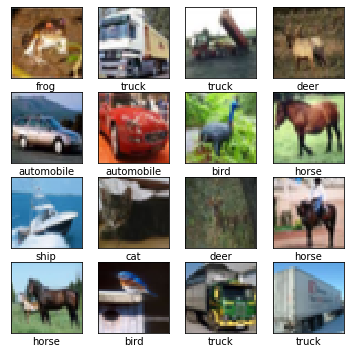

In [4]:
plt.figure(figsize = (6, 6))
for i in range(4*4):
    plt.subplot(4, 4, i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x_train[i])
    plt.xlabel(labels[y_train[i][0]])
plt.show()

Examining the dimensions of our train data, we see 50,000 images.  Each has 32x32 pixels and 3 channels (RGB color values).

In [5]:
x_train.shape

(50000, 32, 32, 3)

Let's confirm the range of RGB values across our images.  As expected, they range from `0` to `255`.

In [6]:
print('min RGB:', x_train.min(axis=0)[0][0])
print('max RGB:', x_train.max(axis=0)[0][0])

min RGB: [0 0 0]
max RGB: [255 255 255]


#### Standardize the data

As we noted above, the RGB values range from 0 to 255, so we divide by 255 to standardize the data.

<ins>Note:</ins> We choose **not** to create a separate validation set here because we do not intend to tune hyper parameters or select a best-performing model.  Model comparisons are for academic purposes.

In [7]:
x_train, x_test = x_train / 255.0, x_test / 255.0

Let's take a peek at our standardized data.  Specficially, let's look at the RGB values of the first pixel in the first image.  As expected, they fall between 0 and 1.

In [8]:
# standardized RGB values of first pixel of first image
x_train[0][0][0]

array([0.23137255, 0.24313725, 0.24705882])

And let's also take a peek at the volume of data in our train set.  It's quite a lot!

In [9]:
# 153.6MM flattened data points
print('flattened values [ in total]:', 50000 * 32 * 32 * 3)
print('flattened values [per image]:', 32 * 32 * 3)
print('flattened pixels [per image]:', 32 * 32)

flattened values [ in total]: 153600000
flattened values [per image]: 3072
flattened pixels [per image]: 1024


Examining class balance, we actually see perfect balance in our training data.  Certainly no additional steps needed to address that.

In [10]:
np.unique(y_train[:, 0], return_counts=True)

(array([0, 1, 2, 3, 4, 5, 6, 7, 8, 9], dtype=uint8),
 array([5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000, 5000]))

And we'll set seeds for replicability, too.

In [11]:
random_state = 99

# set seeds
seed(random_state)
tf.random.set_seed(random_state)

When we set up our neural network, we'll add layers sequentially.  These are the parameters we'll be setting for our convolutional layer.

Our first model will be on the training data as-is, and without any dilation.

| Parameter | Input Type | Description |
| :- | :- | :- |
| filters | integer | dimension of output |
| kernel_size | tuple | height and width of convolution window |
| strides | integer | pixel step size on each iteration through image |
| padding | \[valid, same\] | "valid": no padding; "same": even padding |
| data_format | \[channels_first, channels_last\] | specify channel location within ndarray |
| dilation_rate | integer | pixel step size *within* a convolution window |

*FYI: Clear the model if necessary*

In [12]:
# clear model (if necessary)
tf.keras.backend.clear_session()


In our first convolutional layer, we specify 32 filters, or sets of weights.  Each filter has 8x8x3 parameters.. plus a bias term (based on the kernel size and # of channels).  We move the center of our filter (our moving window) by 2 pixels on each forward pass (`stride = 2`) and use a ReLU activation function.
- Note: `Padding = 'same'` is effectively setting `padding = 3` in this case (given a kernel size of 8, stride of 2, and image size of 32).
- We'll also accept the default filter initialization value (random from glorot uniform)

We then apply max pooling, condensing each filter by a factor of 2 (since we set `pool_size = 2x2`).

Finally, we flatten and add a dense layer activated by a sigmoid function. We specify `units = 10` since that is the number of classes we are predicting on.

In [13]:
# initialize model
model = tf.keras.Sequential()

# add convolutional layer
model.add(Conv2D(filters = 32,  # output 32 sets of weights 
                 kernel_size = (8, 8), # fit (32 * 8 * 8 * 3) + (32) = 6,176 weights
                 strides = 2,
                 padding = 'same',
                 input_shape = (32, 32, 3), # accept 32x32x3 img (matrix)
                 activation = 'relu',
                 data_format = 'channels_last'
                ))

# add condensed layer (via max pooling) 
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten to 1d
model.add(Flatten())

# add our output layer (size = 10, since we have 10 classes)
model.add(Dense(units = 10, activation = 'sigmoid'))

From our model summary, we can see how the above calculations played out.

- In our initial layer, the output shape is 16x16x32.  The 16x16 comes from the number of iterations the filter makes on each image.  The 32 is from our chosen # of filters.
- The # of parameters is 6,176.  This comes from our 32 filters * (8 * 8 kernel size) * (3 channels) + 32 bias terms. 
- Max Pooling decreases the 16x16 window to a 8x8, but does not affect the # of filters.
- Flattening results in 2,048 features (32 * 8 * 8 from our Max Pooling shape)
- Finally, our last layer has 20,490 parameters (2048 * 10 + 10 bias)

In [14]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 16, 32)        6176      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 8, 8, 32)          0         
_________________________________________________________________
flatten (Flatten)            (None, 2048)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                20490     
Total params: 26,666
Trainable params: 26,666
Non-trainable params: 0
_________________________________________________________________


We'll initialize our optimizer outside of `model.fit()` so that we can specify the learning rate.  Since this is a multi-class problem, we'll use `categorical_crossentropy` (as opposed to binary). `'sparse'` is just to minimize our data footprint.

In [15]:
# initialize
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

And fitting our model, we see decent learning ability.  It looks like the vast majority of learning happened in the ~5 epcohs, but we'll next define some functions to examine more closely.

In [16]:
# fit model
model_logs = model.fit(x_train, y_train,
                       epochs=25,
                       batch_size=32,
                       validation_data=(x_test, y_test))

Epoch 1/25
1563/1563 [==============================] - 12s 8ms/step - loss: 1.6175 - accuracy: 0.4269 - val_loss: 1.3973 - val_accuracy: 0.5070
Epoch 2/25
1563/1563 [==============================] - 11s 7ms/step - loss: 1.3457 - accuracy: 0.5280 - val_loss: 1.2935 - val_accuracy: 0.5437
Epoch 3/25
1563/1563 [==============================] - 11s 7ms/step - loss: 1.2594 - accuracy: 0.5593 - val_loss: 1.2390 - val_accuracy: 0.5633
Epoch 4/25
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1999 - accuracy: 0.5810 - val_loss: 1.2209 - val_accuracy: 0.5735
Epoch 5/25
1563/1563 [==============================] - 11s 7ms/step - loss: 1.1594 - accuracy: 0.5949 - val_loss: 1.1685 - val_accuracy: 0.5942
Epoch 6/25
1563/1563 [==============================] - 15s 10ms/step - loss: 1.1289 - accuracy: 0.6052 - val_loss: 1.1721 - val_accuracy: 0.5977
Epoch 7/25
1563/1563 [==============================] - 12s 8ms/step - loss: 1.0952 - accuracy: 0.6185 - val_loss: 1.1382 - val_a

This function will help visualize how the neural network is learning over each epoch. We'll also report out how the final epoch performed on the test set.

In [17]:
def model_plots(model, test_set="Test"):

    # cnt of epochs
    epochs = len(model.history['accuracy'])
    final_valid_acc = model.history['val_accuracy'][epochs-1]
    final_valid_loss = model.history['val_loss'][epochs-1]
    
    # set figure, axis properties
    fig, ax = plt.subplots(ncols = 2, nrows = 1)
    fig.set_size_inches(16, 4)
    fig.tight_layout(h_pad = 6, w_pad = 12)

    # make accuracy plot
    sns.lineplot(x = range(1, epochs + 1), y = model.history['accuracy'], ax = ax[0], label = "Train");
    sns.lineplot(x = range(1, epochs + 1), y = model.history['val_accuracy'], ax = ax[0], label = test_set);
    ax[0].title.set_text('Model Accuracy');
    ax[0].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[0].set_xlabel('Epochs')
    ax[0].legend();
    
    # make loss plot
    sns.lineplot(x = range(1, epochs + 1), y = model.history['loss'], ax = ax[1], label = "Train");
    sns.lineplot(x = range(1, epochs + 1), y = model.history['val_loss'], ax = ax[1], label = test_set);
    ax[1].title.set_text('Model Loss');
    ax[1].xaxis.set_major_locator(MaxNLocator(integer=True))
    ax[1].set_xlabel('Epochs')
    ax[1].legend();
    
    # print final stats
    print('\n', test_set, 'Accuracy:', round(final_valid_acc, 3),'\n', test_set, 'Loss:', round(final_valid_loss, 3))

And let's also define a function to inspect the confusion matrix across classes.

In [18]:
def format_cm(y, y_hat, title, labels, norm):
    ''' norm = { 'true', 'pred', 'all', None }'''
    
    # count nbr of classes in labels
    class_cnt = len(np.unique(y, return_counts=True)[0])
    
    # store (normalized) confusion matrix
    cm = np.round(confusion_matrix(y, y_hat, normalize = norm), 3)

    # configure confusion matrix plot
    fig = plt.figure(figsize=(10, 6))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title(title, pad = 30)
    fig.colorbar(cax)
    ax.set_xticks(range(class_cnt))
    ax.set_yticks(range(class_cnt))
    ax.set_xticklabels(labels)
    ax.set_yticklabels(labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')

    for tick in ax.get_xticklabels():
        tick.set_rotation(45)
    
    # show plot and confusion matrix
    plt.show()

And finally a function to spit out a report of our accuracy metrics.

In [19]:
def accuracy_report(y, y_hat):
    # store accuracy metrics (f1, precision, recall, accuracy, + full report)
    f1 = f1_score(y, y_hat, average = 'macro')
    precision = precision_score(y, y_hat, average = 'macro')
    recall = recall_score(y, y_hat, average = 'macro')
    accuracy = accuracy_score(y, y_hat)
    class_rpt = classification_report(y, y_hat, zero_division = 0)
    
    # print accuracy measures
    print("f1: ", round(f1, 4))
    print("precision: ", round(precision, 4))
    print("recall: ", round(recall, 4))
    print("accuracy: ", round(accuracy, 4))
    print("==================================")
    print(class_rpt)

In our baseline model, we see a pretty large gap open up between the accuracy/loss metrics on the Train data vs. the Test data.

Given that we did not do much to regularize our data or model, this isn't too surprising.


 Test Accuracy: 0.623 
 Test Loss: 1.144


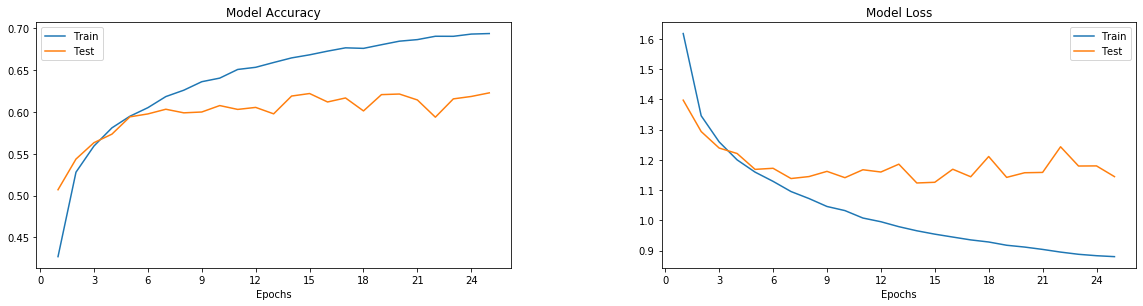

In [20]:
model_plots(model_logs)

Looking at the confusion matrix, we see *most* predictions fall along the diagonal (correctly), but it's hard to see the broader trends.  We'll apply some nicer formatting below to take a better look.

In [21]:
# Confusion matrix for test set
p_hat = model.predict(x_test)
y_hat = np.argmax(p_hat, axis=1)
cm_data = confusion_matrix(y_hat, y_test)

conf_df = pd.DataFrame(cm_data, columns=labels, index=labels)
conf_df

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,680,29,57,22,23,10,11,20,102,39
automobile,33,730,7,19,7,11,12,8,54,126
bird,84,14,490,107,81,73,47,49,25,20
cat,18,13,43,327,37,111,45,30,14,14
deer,23,6,130,97,602,73,71,78,15,17
dog,11,6,97,202,44,538,33,66,12,8
frog,18,12,97,143,85,75,756,26,17,17
horse,15,12,54,53,100,83,11,697,9,31
ship,56,22,13,7,13,13,4,2,705,24
truck,62,156,12,23,8,13,10,24,47,704


And with this color coding it's a bit easier to pick out the trends.  It looks like this model did a pretty good job of picking out `'ship'` images.

Seems like it struggled with some of the animals; specifically cat and dog seem to get mixed up a noticeable amount of the time.

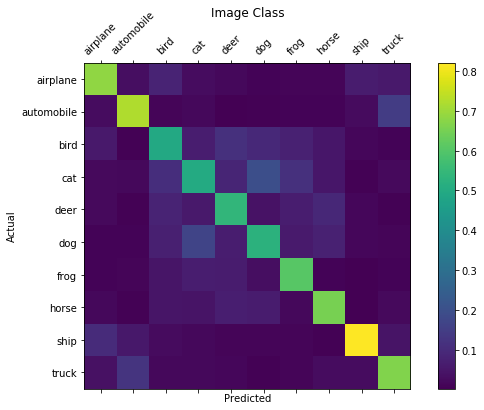

In [22]:
format_cm(y_test, y_hat, 'Image Class', labels, 'pred')

And the accuracy report shows this as well.  The ship class (index `8`) had the highest f1, while cats (index `3`) were the worst.

Overall, we ended up with accuracy of 62% on our test set (out of 10 classes); not perfect, but much better than guessing!

In [23]:
accuracy_report(y_test, y_hat)

f1:  0.6192
precision:  0.6223
recall:  0.6229
accuracy:  0.6229
              precision    recall  f1-score   support

           0       0.68      0.68      0.68      1000
           1       0.72      0.73      0.73      1000
           2       0.49      0.49      0.49      1000
           3       0.50      0.33      0.40      1000
           4       0.54      0.60      0.57      1000
           5       0.53      0.54      0.53      1000
           6       0.61      0.76      0.67      1000
           7       0.65      0.70      0.68      1000
           8       0.82      0.70      0.76      1000
           9       0.66      0.70      0.68      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



## Data Augmentation

To deal with the overfitting we saw above, we'll try augmenting our data would transformed versions of our original images (which should act as a form of regularization).  Specifically, we'll rotate and crop a random sample of images and add them into our train set.

#### Image Rotation

First, we'll define a function that applies a random rotation to an image.

A couple notes on paramater decisions:
- `reshape = False` keeps image at original size (so the edges are essentially cropped).  If we want to resize the image so that *after* rotation, the entire image still fits, then use `reshape = True`
- `cval` is where we specify how to fill the remaining white space that results from the rotation.  Doesn't seem to be working quite properly... maybe because we standardized the RGB inputs earlier?

In [24]:
def image_rotate(img):
    
    # randomly choose an angle to rotate image 
    rand_angle = np.random.choice(range(1, 360))
    
    # loop through each channel (RGB) and apply rotation
    for i in range(3):
        img[:, :, i] = ndimage.rotate(
            input = img[:, :, i], 
            angle = rand_angle, 
            cval = img[:, :, i].min(), 
            reshape = False)
    
    return img

#### Image Cropping

Next we'll define a function to randomly crop an image.  After cropping the image, we'll resize it back to it's original dimensions (`32 x 32 x 3`, in this case).

In [25]:
# Random crop function:
def image_crop(img):
    
    # image dimensions
    lx, ly = img.shape[:2]
    
    # randomly choose proportion of image to crop
    rand_crop_proportion = np.random.choice([6, 8, 10])
    
    # crop dimensions
    y_crop1 = ly // rand_crop_proportion
    y_crop2 = - ly // rand_crop_proportion
    x_crop1 = lx // rand_crop_proportion
    x_crop2 = - lx // rand_crop_proportion
    
    # crop image
    img = img[x_crop1:x_crop2, y_crop1:y_crop2, :]

    # resize cropped image back to original size
    img = transform.resize(img, (lx, ly, 3), order=1)
    
    return img

And let's define a function to visually check that these functions have the expected output.

In [26]:
def compare_alteration(img_index, fn):
    
    # copy image
    my_image = x_train[img_index].copy()

    # figure, axis settings
    fig = plt.figure(figsize=(10, 4))
    ax1, ax2 = fig.subplots(1, 2)

    # original image
    ax1.imshow(x_train[img_index])
    ax1.set_title('Original Image')
    ax1.set_xlabel(labels[y_train[img_index][0]])
    
    if fn == 'rotate':
        # rotated image
        ax2.imshow(image_rotate(my_image))
        ax2.set_title('Rotated Image')
        ax2.set_xlabel(labels[y_train[img_index][0]])
    elif fn == 'crop':
        # cropped image
        ax2.imshow(image_crop(my_image))
        ax2.set_title('Cropped Image')
        ax2.set_xlabel(labels[y_train[img_index][0]])
    
    plt.show();

Let's check an arbitrary rotated image - looks good.

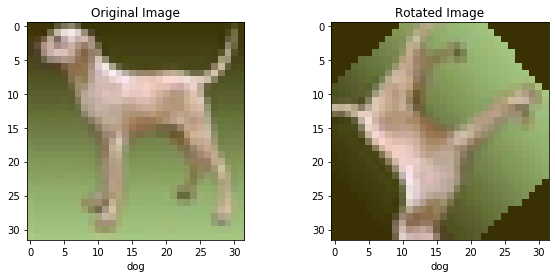

In [27]:
compare_alteration(9999, 'rotate')

And now let's check an arbitrary cropped image - also looks good.

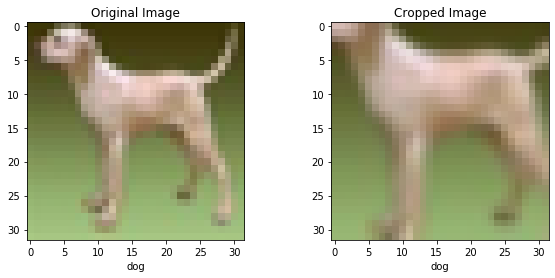

In [28]:
compare_alteration(9999, 'crop')

Before applying any transformations let's make a copy of our data to ensure we don't edit the originals.

In [29]:
# make a copy to avoid altering originals
x_train_copy = x_train.copy()
y_train_copy = y_train.copy()

Wel'll take two samples (without replacement) from our original data to apply rotation or cropping to.  Note that there could be overlap between the images chosenn for rotation and those chosen for cropping.

Here we choose our sample proportion (`0.15`) for **each** transformation, take the random samples, and finally convert them back to numpy arrays.

In [30]:
# set sample proportion
sample_pct = 0.15
sample_n = int(x_train_copy.shape[0] * sample_pct)

# take random samples without replacement
x_rotate, y_rotate = zip(*random.sample(list(zip(x_train_copy, y_train_copy)), k = sample_n))
x_crop, y_crop = zip(*random.sample(list(zip(x_train_copy, y_train_copy)), k = sample_n))

# convert back to np array
x_rotate = np.array(x_rotate)
x_crop = np.array(x_crop)
y_rotate = np.array(y_rotate)
y_crop = np.array(y_crop)

After applying the transfomrations let's make sure that dimensions of our new images look as expected.  We see that they do.

In [31]:
print('x dimensions:', x_rotate.shape)
print('y dimensions:', y_rotate.shape)

x dimensions: (7500, 32, 32, 3)
y dimensions: (7500, 1)


And now let's concatenate the new images to original data and double check to make sure these dimensions also look correct.

In [32]:
# apply transformations to sampled images
for i in range(sample_n):
    x_rotate[i] = image_rotate(x_rotate[i])
    x_crop[i] = image_crop(x_crop[i])

# augment the original data with the transformed images
x_train = np.concatenate((x_train, x_rotate, x_crop), axis = 0)
y_train = np.concatenate((y_train, y_rotate, y_crop), axis = 0)

# double check that dimensions look as expected
print(x_train.shape)
print(y_train.shape)

(65000, 32, 32, 3)
(65000, 1)


Let's build out our CNN layers again, matching our first model.  The difference this time will be when we fit the model - it'll be based on an augmented dataset.

In [33]:
# clear model
tf.keras.backend.clear_session()

# initialize model
model = tf.keras.Sequential()

# add convolutional layer
model.add(Conv2D(filters = 32,  # output 32 sets of weights 
                 kernel_size = (8, 8), # fit (32 * 8 * 8 * 3) + (32) = 6,176 weights
                 strides = 2,
                 padding = 'same',
                 input_shape = (32, 32, 3), # accept 32x32x3 img (matrix)
                 activation = 'relu',
                 data_format = 'channels_last'
                ))

# add condensed layer (via max pooling) 
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten to 1d
model.add(Flatten())

# add our output layer (size = 10, since we have 10 classes)
model.add(Dense(units = 10, activation = 'sigmoid'))

Since we're using the same layer scheme as before (just passing in our augmented data this time), we'll pass over taking another look at the `model.summary()`.

Now let's fit the model.

In [34]:
# initialize
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

# fit model
model_logs = model.fit(x_train, y_train,
                       epochs=25,
                       batch_size=32,
                       validation_data=(x_test, y_test))

Epoch 1/25
2032/2032 [==============================] - 15s 8ms/step - loss: 1.6488 - accuracy: 0.4164 - val_loss: 1.5019 - val_accuracy: 0.4829
Epoch 2/25
2032/2032 [==============================] - 15s 7ms/step - loss: 1.4342 - accuracy: 0.4976 - val_loss: 1.3264 - val_accuracy: 0.5319
Epoch 3/25
2032/2032 [==============================] - 15s 7ms/step - loss: 1.3564 - accuracy: 0.5314 - val_loss: 1.2351 - val_accuracy: 0.5690
Epoch 4/25
2032/2032 [==============================] - 15s 7ms/step - loss: 1.2988 - accuracy: 0.5521 - val_loss: 1.2117 - val_accuracy: 0.5730
Epoch 5/25
2032/2032 [==============================] - 18s 9ms/step - loss: 1.2579 - accuracy: 0.5639 - val_loss: 1.2094 - val_accuracy: 0.5777
Epoch 6/25
2032/2032 [==============================] - 18s 9ms/step - loss: 1.2234 - accuracy: 0.5773 - val_loss: 1.1485 - val_accuracy: 0.6001
Epoch 7/25
2032/2032 [==============================] - 15s 7ms/step - loss: 1.1980 - accuracy: 0.5866 - val_loss: 1.1247 - val_ac

While we see a small gap still open up between the train and test set, it occurs *much* later (around 15 epochs... as oppose to around 5) and is also a much smaller gap.

Our test accuracy is the same as before, but our train accuracy now matches more closely.


 Test Accuracy: 0.62 
 Test Loss: 1.154


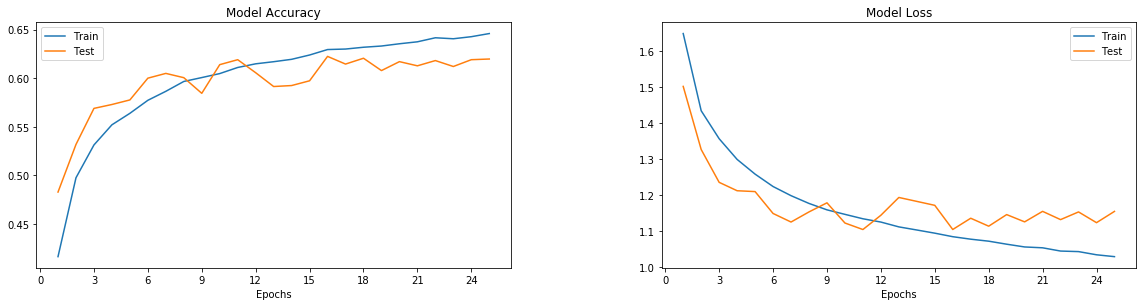

In [35]:
model_plots(model_logs)

Looking at the raw confusion matrix, it looks like the most common mistake was predicting `'cat'` when the image was actually a `'dog'`.  Let's take a look at the heat map confusion matrix.

In [36]:
# Confusion matrix for test set
p_hat = model.predict(x_test)
y_hat = np.argmax(p_hat, axis=1)
cm_data = confusion_matrix(y_hat, y_test)

conf_df = pd.DataFrame(cm_data, columns=labels, index=labels)
conf_df

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,713,38,106,52,66,25,19,54,88,77
automobile,20,769,16,27,12,16,25,17,46,143
bird,42,3,424,59,68,56,47,37,8,11
cat,22,10,51,367,53,144,54,36,9,6
deer,13,2,139,91,579,61,83,89,5,5
dog,9,5,101,225,46,559,49,78,13,7
frog,10,5,76,83,72,32,684,13,2,9
horse,7,3,32,29,63,50,6,623,4,13
ship,129,42,40,34,36,42,17,15,804,53
truck,35,123,15,33,5,15,16,38,21,676


Interestingly, this model did better with horses and worse with ships compared to the last one.  So even though overall accuracy is about the same, it varies by class.

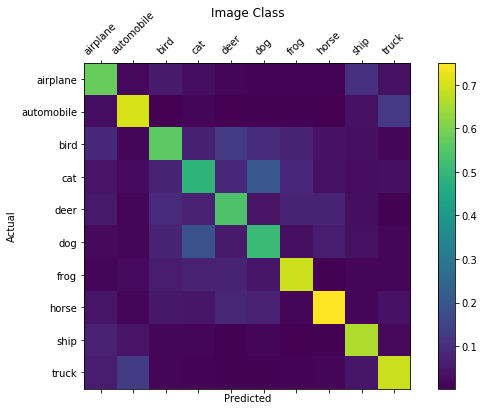

In [37]:
format_cm(y_test, y_hat, 'Image Class', labels, 'pred')

It looks like cats (index `3`) are still the hardest class to predict, although birds (index `2`) aren't much better.

In [38]:
accuracy_report(y_test, y_hat)

f1:  0.615
precision:  0.6185
recall:  0.6198
accuracy:  0.6198
              precision    recall  f1-score   support

           0       0.58      0.71      0.64      1000
           1       0.70      0.77      0.74      1000
           2       0.56      0.42      0.48      1000
           3       0.49      0.37      0.42      1000
           4       0.54      0.58      0.56      1000
           5       0.51      0.56      0.53      1000
           6       0.69      0.68      0.69      1000
           7       0.75      0.62      0.68      1000
           8       0.66      0.80      0.73      1000
           9       0.69      0.68      0.68      1000

    accuracy                           0.62     10000
   macro avg       0.62      0.62      0.62     10000
weighted avg       0.62      0.62      0.62     10000



## Dilation

Next, we'll rebuild our model, but this time with dilation.  Since tensorflow doesn't currently support it, we'll remove our stride of 2 (replaced with the default `stride = 1`).

Dilation should also act as a form of regularization as we add space between the pixels that our model takes in on each forward pass (acting as an image distortion of sorts).

We'll also apply this model to our augmented data and see how it compares.

In [39]:
# clear model
tf.keras.backend.clear_session()

# initialize new model
model = tf.keras.Sequential()

# this time we'll replace the stride with a dilation_rate
model.add(Conv2D(filters = 32,  # output 32 sets of weights 
                 kernel_size = (8, 8), # fit (32 * 8 * 8 * 3) + (32) = 6,176 weights
                 dilation_rate = 2,
                 padding = 'same',
                 input_shape = (32, 32, 3), # accept 32x32x3 img (matrix)
                 activation = 'relu',
                 data_format = 'channels_last'
                ))

# add condensed layer (via max pooling) 
model.add(MaxPooling2D(pool_size=(2, 2)))

# flatten to 1d
model.add(Flatten())

# add our output layer (size = 10, since we have 10 classes)
model.add(Dense(units = 10, activation = 'sigmoid'))

From our model summary, we can see how the above calculations played out as compared to the original model that *didn't* have `dilation_rate = 2`, but *did* have `stride = 2`

- In our initial layer, the output shape increased by a factor of 4 since we dropped the stride.  32x32x32.
- However, the # of parameters (6,176) stayed the same. This is because we kept the same filters (32) and kernel size (8x8)
- Max Pooling decreased window similarly (by 4), but this time down to a 16x16 window (instead of 8x8).
- Flattening results in 8,192 features (32 * 16 * 16 from our Max Pooling shape)
- Finally, our last layer has 81,930 parameters (8192 * 10 + 10 bias)

In [40]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 32, 32, 32)        6176      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 16, 32)        0         
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 10)                81930     
Total params: 88,106
Trainable params: 88,106
Non-trainable params: 0
_________________________________________________________________


And now let's fit our model.

In [41]:
# initialize
opt = tf.keras.optimizers.Adam(learning_rate=0.001)
model.compile(loss='sparse_categorical_crossentropy', optimizer=opt, metrics = ['accuracy'])

# fit model
model_logs = model.fit(x_train, y_train,
                       epochs=25,
                       batch_size=32,
                       validation_data=(x_test, y_test))

Epoch 1/25
2032/2032 [==============================] - 64s 31ms/step - loss: 1.7184 - accuracy: 0.3903 - val_loss: 1.5454 - val_accuracy: 0.4569
Epoch 2/25
2032/2032 [==============================] - 56s 27ms/step - loss: 1.5036 - accuracy: 0.4720 - val_loss: 1.4325 - val_accuracy: 0.4935
Epoch 3/25
2032/2032 [==============================] - 59s 29ms/step - loss: 1.4208 - accuracy: 0.5049 - val_loss: 1.2911 - val_accuracy: 0.5456
Epoch 4/25
2032/2032 [==============================] - 54s 26ms/step - loss: 1.3525 - accuracy: 0.5281 - val_loss: 1.2849 - val_accuracy: 0.5543
Epoch 5/25
2032/2032 [==============================] - 54s 27ms/step - loss: 1.3097 - accuracy: 0.5459 - val_loss: 1.2733 - val_accuracy: 0.5570
Epoch 6/25
2032/2032 [==============================] - 55s 27ms/step - loss: 1.2671 - accuracy: 0.5611 - val_loss: 1.2385 - val_accuracy: 0.5735
Epoch 7/25
2032/2032 [==============================] - 54s 27ms/step - loss: 1.2350 - accuracy: 0.5725 - val_loss: 1.2662 -

Interestingly, dilation really harmed our accuracy on the test set, pushing it down about 5% (to 57%).  The training set accuracy is back up to ~70% (where it was in our original model).

So this actually resulted in a worse test accuracy than both other models **and** worse overfitting than both other models.



 Test Accuracy: 0.571 
 Test Loss: 1.42


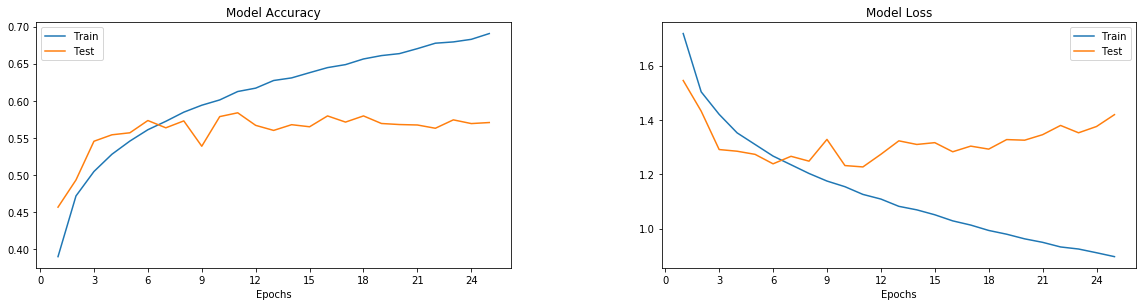

In [42]:
model_plots(model_logs)

Many predictions still fall along the diagonal, but let's examine this in a more digestable way.

In [43]:
# Confusion matrix for test set
p_hat = model.predict(x_test)
y_hat = np.argmax(p_hat, axis=1)
cm_data = confusion_matrix(y_hat, y_test)

conf_df = pd.DataFrame(cm_data, columns=labels, index=labels)
conf_df

,airplane,automobile,bird,cat,deer,dog,frog,horse,ship,truck
airplane,754,71,126,56,72,45,33,57,176,97
automobile,40,736,32,39,16,24,28,26,76,166
bird,44,10,383,75,77,87,58,43,16,16
cat,13,4,58,346,55,184,54,42,11,14
deer,16,1,132,80,527,71,65,76,7,8
dog,6,4,65,164,37,392,42,59,10,8
frog,12,9,94,96,79,42,675,20,4,7
horse,9,3,63,75,100,99,20,633,8,12
ship,67,34,26,31,27,28,9,6,636,46
truck,39,128,21,38,10,28,16,38,56,626


While the *relative* prediction accuracy looks pretty similar across clases as before (vehicles better than animals)... we notice that legend stops around 65% (lower than before).

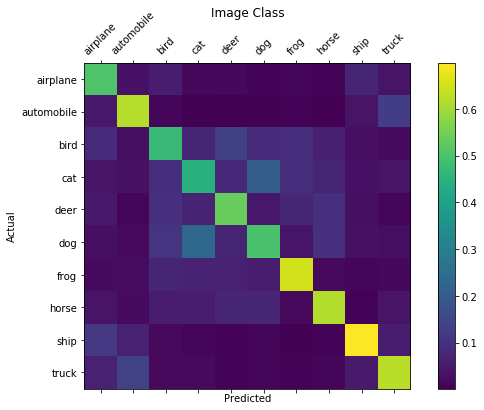

In [44]:
format_cm(y_test, y_hat, 'Image Class', labels, 'pred')

And our summary statistics tell a similar story.  Prediction across all classes got a little worse.

In [45]:
accuracy_report(y_test, y_hat)

f1:  0.5643
precision:  0.5674
recall:  0.5708
accuracy:  0.5708
              precision    recall  f1-score   support

           0       0.51      0.75      0.61      1000
           1       0.62      0.74      0.67      1000
           2       0.47      0.38      0.42      1000
           3       0.44      0.35      0.39      1000
           4       0.54      0.53      0.53      1000
           5       0.50      0.39      0.44      1000
           6       0.65      0.68      0.66      1000
           7       0.62      0.63      0.63      1000
           8       0.70      0.64      0.67      1000
           9       0.63      0.63      0.63      1000

    accuracy                           0.57     10000
   macro avg       0.57      0.57      0.56     10000
weighted avg       0.57      0.57      0.56     10000



## Summary

In summary, all of our models hovered around 60% accuracy on the test set, but each was a bit different.  Overall, our 2nd model with augmented data was probably the best performing as it suffered the least from overfitting while still maintaining test accuracy (62%).

Our first model, which did **not** augment the data did fine, but suffered from overfitting.

Our last model, with dilation appeared to do the worst of all, with the lowest test accuracy and the most overfitting.  In a future exercise, it would be good to explore how different learning rates would affect each of these models, and also whether dilation is best performed on **unagumented** data.